<a href="https://colab.research.google.com/github/mayankkom-dev/COMP8610/blob/main/Assignment02_NNDL_pyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian

In [ ]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

MNIST Parameter and Model Initial parameter

Downloading MNIST DATA

In [ ]:
dataset = MNIST(root="MNIST", train=True, transform=transforms.ToTensor(), download=True)

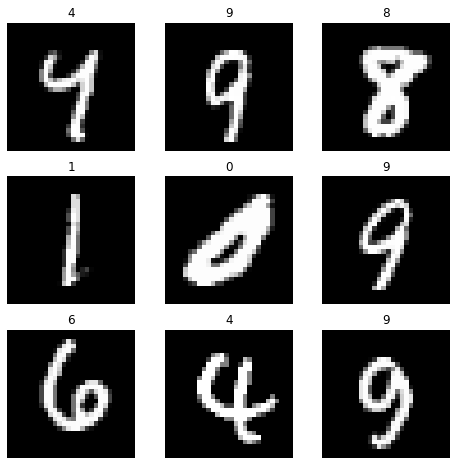

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Train, Test, Val Split

In [ ]:
# Download dataset
dataset = MNIST(root="MNIST", train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset,  [50000, 10000], generator=torch.Generator().manual_seed(1))
# train_subset, val_subset = random_split(dataset,  [50000, 10000], generator=torch.Generator().manual_seed(1))

# train_ds = train_subset.dataset.data[train_subset.indices]
# y_train = train_subset.dataset.targets[train_subset.indices]
# val_ds = val_subset.dataset.data[val_subset.indices]
# y_val = val_subset.dataset.targets[val_subset.indices]

test_ds = MNIST(root="MNIST", train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

50000 10000 10000


Few Hyperparameter

In [ ]:
# Hyperparmeters
batch_size = 32
learning_rate = 0.001
# Other constants
input_size = 28*28
num_classes = 10

In [ ]:
# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

Sneek into Train Data

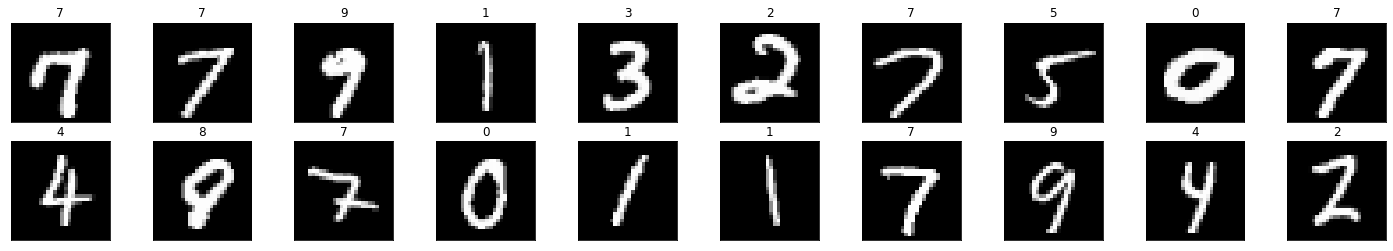

In [ ]:
import numpy as np

classes = list(range(10))
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(images[idx].squeeze(), cmap="gray")
  ax.set_title(classes[labels[idx].item()])

# Model Def

In [ ]:
# # code for Model with Dropout enabled -- Working to refactor
# from torch.nn import NLLLoss

# class MnistModelDP(nn.Module):
#     def __init__(self, w_init="xavier_uniform"):
#         super().__init__()
#         self.linear = nn.Linear(input_size, num_classes)
#         self.linear2 = nn.Linear(num_classes, num_classes)
#         if w_init=="xavier_uniform": 
#           torch.nn.init.xavier_uniform_(self.linear.weight)
#           torch.nn.init.xavier_uniform_(self.linear2.weight)
#         if w_init=="ones": 
#           torch.nn.init.ones_(self.linear.weight)
#           torch.nn.init.ones_(self.linear2.weight)
#         if w_init=="zeros": 
#           torch.nn.init.zeros_(self.linear.weight)
#           torch.nn.init.zeros_(self.linear2.weight)
#         self.dropout = nn.Dropout(0.3)
        
#     def forward(self, xb):
#         xb = xb.reshape(-1, 784)
#         out = torch.sigmoid(self.linear(xb))
#         out = self.dropout(out)
#         out2 = torch.sigmoid(self.linear2(out))
#         return out2
    
#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
#     def validation_step(self, batch):
#         images, labels = batch 
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss cross_entropy
#         acc = accuracy(out, labels)           # Calculate accuracy
#         # self.log("val_loss", loss.detach())
#         return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

### Logistic Regression with 1 Hidden Layer

In [ ]:
# code block for Deep Neural Network - Logistic Regression with 1 hidden unit
## now supports Dropout initialization
from torch.nn import NLLLoss

class MnistModel2(nn.Module):
    def __init__(self, w_init="xavier_uniform", dropout_=None):
      super().__init__()
      self.dropout_ = dropout_
      self.linear = nn.Linear(input_size, num_classes)
      self.linear2 = nn.Linear(num_classes, num_classes)
      if w_init=="xavier_uniform": 
        torch.nn.init.xavier_uniform_(self.linear.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
      if w_init=="ones": 
        torch.nn.init.ones_(self.linear.weight)
        torch.nn.init.ones_(self.linear2.weight)
      if w_init=="zeros": 
        torch.nn.init.zeros_(self.linear.weight)
        torch.nn.init.zeros_(self.linear2.weight)
      if self.dropout_: self.dropout = nn.Dropout(0.3)
      
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = torch.sigmoid(self.linear(xb))
        if self.dropout_: out = self.dropout(out)
        out2 = torch.sigmoid(self.linear2(out))
        return out2

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss cross_entropy
        acc = accuracy(out, labels)           # Calculate accuracy
        # self.log("val_loss", loss.detach())
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

### Simple Logistic Regression 

In [ ]:
# code block for simple logistic regression, stacking n_class lr's to create NN for multiclass classification
from torch.nn import NLLLoss

class MnistModel(nn.Module):
    def __init__(self, w_init="xavier_uniform"):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        if w_init=="xavier_uniform": torch.nn.init.xavier_uniform_(self.linear.weight)
        if w_init=="ones": torch.nn.init.ones_(self.linear.weight)
        if w_init=="zeros": torch.nn.init.zeros_(self.linear.weight)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = torch.sigmoid(self.linear(xb))
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss cross_entropy
        acc = accuracy(out, labels)           # Calculate accuracy
        # self.log("val_loss", loss.detach())
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
# Fit For All Model class with regularization paramter
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD,  weight_decay=0):
    history = []
    optimizer = opt_func(model.parameters(), lr,  weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return model, history

In [ ]:
# modularized plot function
def plot(history1, mode="acc"):
  xs = [r[f'val_{mode}'] for r in history1]
  plt.plot(xs, '-x')
  plt.xlabel('epoch')
  plt.ylabel(f'{mode}')
  plt.title(f'{mode.title()} vs. No. of epochs')
  plt.show()


In [ ]:
def sub_plot(history1, mode="acc", st=None, en=None):
  if st: history1 = history1[st:]
  if en: history1 = history1[:en]
  xs = [r[f'val_{mode}'] for r in history1]
  plt.plot(xs, '-x')
  plt.xlabel('epoch')
  plt.ylabel(f'{mode}')
  plt.title(f'{mode.title()} vs. No. of epochs')
  plt.show()


In [ ]:
def combine_plot(h_list, mname, mode="acc" , loc="lower right", st=None, en=None):
  for i, history1 in enumerate(h_list):
    if st: history1 = history1[st:]
    if en: history1 = history1[:en]
    xs = [r[f'val_{mode}'] for r in history1]
    plt.plot(xs, '-x', label=mname[i])
  
  plt.legend(loc=loc)
  plt.xlabel('epoch')
  plt.ylabel(f'{mode}')
  plt.title(f'{mode.title()} vs. No. of epochs')
  plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model_test_classification(testloader, net):
  classes = list(range(10))
  y_true = []
  y_pred = []

  # again no gradients needed
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = net(images)
          _, predictions = torch.max(outputs, 1)
          y_true.extend(labels)
          y_pred.extend(predictions)  
  # sklearn classification score
  target_names = [f'class {i}' for i in range(10)]
  print(classification_report(y_true, y_pred, target_names=target_names))
  cf_matrix = confusion_matrix(y_true, y_pred)
  import seaborn as sns
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots(figsize=(10,10)) 

  sns.heatmap(cf_matrix, annot=True,  ax=ax, cmap="YlGnBu", fmt='d')

In [ ]:
import numpy as np
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image
# vizualize model prediction and true value on actual image
def evaluate_model_test(test_loader, model):
  classes = list(range(10))

  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  output = model(images)
  _, preds = torch.max(output, 1)

  fig = plt.figure(figsize=(25, 4))

  for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

1.	Try the basic minibatch SGD. It is recommended to try different initializations, different batch sizes, and different learning rates, in order to get a sense about how to tune the hyperparameters (batch size, and, learning rate). Remember to create and use validation dataset!. it will be very useful for you to read Chapter-11 of the textbook.

In [ ]:
# # experiment MnistModelDP for NN with 1 hiden layer of 10 units with dropout
# def experimentDP(train_ds, val_ds, test_ds, epochs, batch_size,  w_init, lr, opt=torch.optim.SGD, c=0, dropout_=None):
#   # Dataloaders
#   train_loader = DataLoader(train_ds, batch_size, shuffle=True)
#   val_loader = DataLoader(val_ds, batch_size)
#   test_loader = DataLoader(test_ds, batch_size)
#   # initialize model
#   model = MnistModel2(w_init=w_init, dropout_=dropout_)
#   print(f'Before training {evaluate(model, val_loader)}')
#   # train the model
#   history1 = fit(epochs, lr, model, train_loader, val_loader, opt_func=opt, weight_decay=c)
#   # plot the graphs on val
#   plot(history1, mode="acc")
#   plot(history1, mode="loss")
#   #todo include test acc and plot all acc on a single plot
#   return model, history1

In [ ]:
# experimentMLR for LR with 1 hiden layer of 10 units with regularizer, initializer, dropout, optimizer all are configurable
def experimentMLR(train_ds, val_ds, test_ds, epochs, batch_size,  w_init, lr, opt=torch.optim.SGD, c=0, dropout_=None):
  # Dataloaders
  train_loader = DataLoader(train_ds, batch_size, shuffle=True)
  val_loader = DataLoader(val_ds, batch_size)
  test_loader = DataLoader(test_ds, batch_size)
  # initialize model
  model = MnistModel2(w_init=w_init, dropout_=dropout_)
  print(f'Before training {evaluate(model, val_loader)}')
  # train the model
  model, history1 = fit(epochs, lr, model.to_d, train_loader, val_loader, opt_func=opt, weight_decay=c)
  # plot the graphs on val
  plot(history1, mode="acc")
  plot(history1, mode="loss")
  return model, history1

In [ ]:
def experimentSLR(train_ds, val_ds, test_ds, epochs, batch_size,  w_init, lr, opt=torch.optim.SGD, c=0):
  # Dataloaders
  train_loader = DataLoader(train_ds, batch_size, shuffle=True)
  val_loader = DataLoader(val_ds, batch_size)
  test_loader = DataLoader(test_ds, batch_size)
  # initialize model
  model = MnistModel(w_init=w_init)
  print(f'Before training {evaluate(model, val_loader)}')
  # train the model
  model, history1 = fit(epochs, lr, model, train_loader, val_loader, opt_func=opt, weight_decay=c)
  # plot the graphs on val
  plot(history1, mode="acc")
  plot(history1, mode="loss")
  return model, history1

In [ ]:
train_ds.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

# W_init Experiments

### W_Ones

Before training {'val_loss': 2.3025856018066406, 'val_acc': 0.10213658213615417}
Epoch [0], val_loss: 2.3026, val_acc: 0.1021
Epoch [1], val_loss: 2.3026, val_acc: 0.1021
Epoch [2], val_loss: 2.3026, val_acc: 0.1021


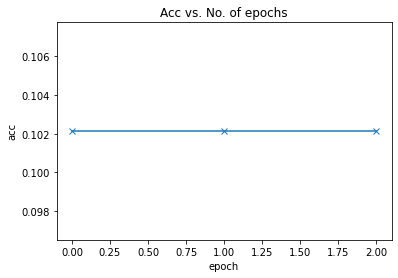

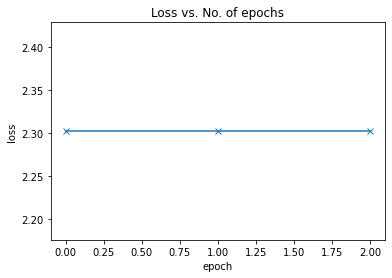

In [ ]:
# weight with all one does not learn anything. All 10 LR learn same thing and same update and overall no learning. 
# Read through and elaborate for report
modelSLR_wones, historySLR_wones = experimentSLR(train_ds, val_ds, test_ds, epochs=3, batch_size=32, w_init="ones", lr=0.001)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     class 0       0.10      1.00      0.18       980
     class 1       0.00      0.00      0.00      1135
     class 2       0.00      0.00      0.00      1032
     class 3       0.00      0.00      0.00      1010
     class 4       0.00      0.00      0.00       982
     class 5       0.00      0.00      0.00       892
     class 6       0.00      0.00      0.00       958
     class 7       0.00      0.00      0.00      1028
     class 8       0.00      0.00      0.00       974
     class 9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



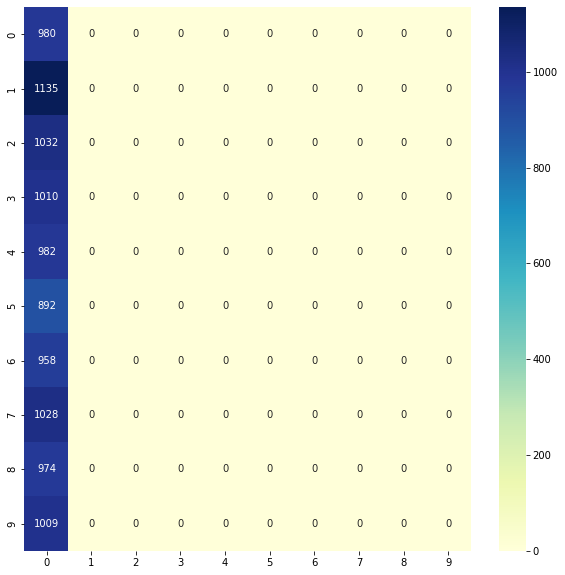

In [ ]:
# performance on test data
evaluate_model_test_classification(test_loader, modelSLR_wones)

W_Init with vector of ones is worst. The model stuck in local optima and can not reduce loss. All the sigmoid unit learn and behave similarly and so all the unit learn similar representation and so the model can not learn even after gd

### W_Zeros

Before training {'val_loss': 2.302522659301758, 'val_acc': 0.09864217042922974}
Epoch [0], val_loss: 2.2069, val_acc: 0.7187
Epoch [1], val_loss: 2.1334, val_acc: 0.7491
Epoch [2], val_loss: 2.0754, val_acc: 0.7672
Epoch [3], val_loss: 2.0289, val_acc: 0.7839
Epoch [4], val_loss: 1.9913, val_acc: 0.7938
Epoch [5], val_loss: 1.9606, val_acc: 0.8017
Epoch [6], val_loss: 1.9350, val_acc: 0.8067
Epoch [7], val_loss: 1.9136, val_acc: 0.8106
Epoch [8], val_loss: 1.8953, val_acc: 0.8152
Epoch [9], val_loss: 1.8795, val_acc: 0.8179


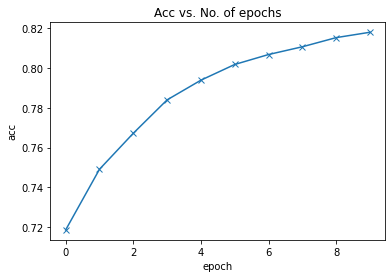

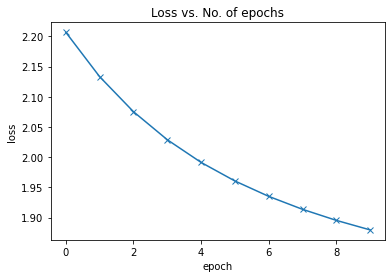

In [ ]:
modelSLR_wzeros, history1SLR_wzeros = experimentSLR(train_ds, val_ds, test_ds, epochs=10, batch_size=32, w_init="zeros", lr=0.001)

              precision    recall  f1-score   support

     class 0       0.89      0.95      0.92       980
     class 1       0.87      0.93      0.90      1135
     class 2       0.87      0.77      0.82      1032
     class 3       0.72      0.87      0.79      1010
     class 4       0.87      0.78      0.82       982
     class 5       0.92      0.51      0.66       892
     class 6       0.86      0.90      0.88       958
     class 7       0.93      0.82      0.87      1028
     class 8       0.70      0.81      0.75       974
     class 9       0.73      0.86      0.79      1009

    accuracy                           0.83     10000
   macro avg       0.84      0.82      0.82     10000
weighted avg       0.84      0.83      0.82     10000



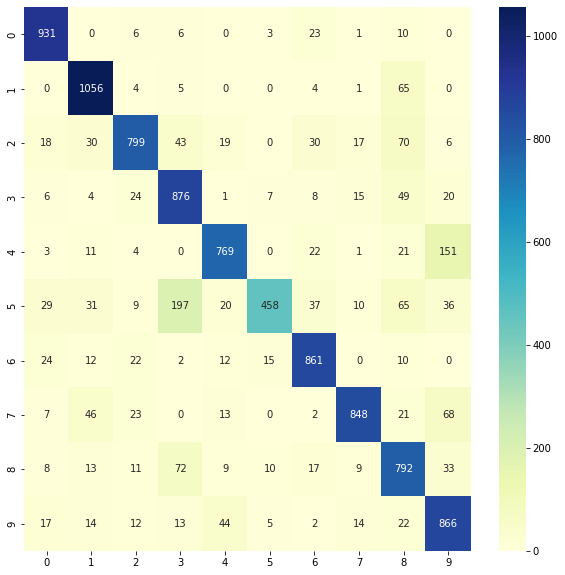

In [ ]:
evaluate_model_test_classification(test_loader, modelSLR_wzeros)

### W_Xavier_uniform

Before training {'val_loss': 2.3071882724761963, 'val_acc': 0.12220447510480881}
Epoch [0], val_loss: 2.2157, val_acc: 0.3595
Epoch [1], val_loss: 2.1427, val_acc: 0.5657
Epoch [2], val_loss: 2.0845, val_acc: 0.6657
Epoch [3], val_loss: 2.0377, val_acc: 0.7153
Epoch [4], val_loss: 1.9996, val_acc: 0.7456
Epoch [5], val_loss: 1.9682, val_acc: 0.7639
Epoch [6], val_loss: 1.9420, val_acc: 0.7768
Epoch [7], val_loss: 1.9198, val_acc: 0.7839
Epoch [8], val_loss: 1.9009, val_acc: 0.7891
Epoch [9], val_loss: 1.8846, val_acc: 0.7941


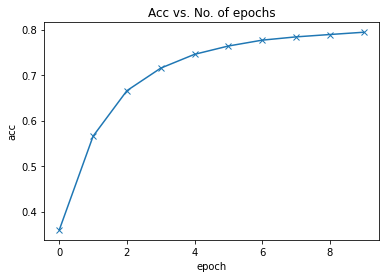

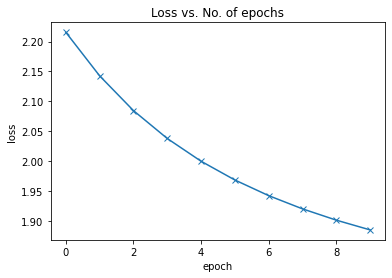

In [ ]:
modelSLR_wxavier, history1SLR_wxavier = experimentSLR(train_ds, val_ds, test_ds, epochs=10, batch_size=32, w_init="xavier_uniform", lr=0.001)

              precision    recall  f1-score   support

     class 0       0.87      0.94      0.90       980
     class 1       0.86      0.92      0.89      1135
     class 2       0.84      0.75      0.79      1032
     class 3       0.74      0.86      0.79      1010
     class 4       0.83      0.74      0.78       982
     class 5       0.91      0.52      0.66       892
     class 6       0.86      0.86      0.86       958
     class 7       0.91      0.82      0.86      1028
     class 8       0.69      0.80      0.74       974
     class 9       0.69      0.83      0.75      1009

    accuracy                           0.81     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.81      0.81     10000



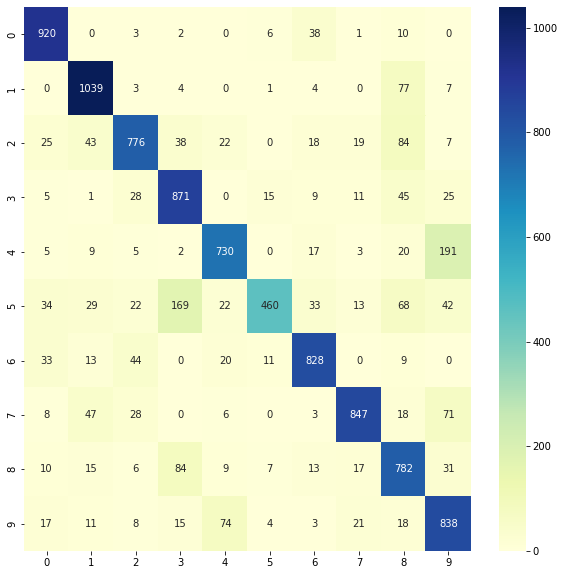

In [ ]:
evaluate_model_test_classification(test_loader, modelSLR_wxavier)

# Learning Rate Experiments

### W_zeros High LR

Before training {'val_loss': 2.3025074005126953, 'val_acc': 0.09864217042922974}
Epoch [0], val_loss: 1.5903, val_acc: 0.8911
Epoch [1], val_loss: 1.5790, val_acc: 0.8966
Epoch [2], val_loss: 1.5737, val_acc: 0.9007
Epoch [3], val_loss: 1.5709, val_acc: 0.9018
Epoch [4], val_loss: 1.5671, val_acc: 0.9049
Epoch [5], val_loss: 1.5659, val_acc: 0.9059
Epoch [6], val_loss: 1.5639, val_acc: 0.9048
Epoch [7], val_loss: 1.5621, val_acc: 0.9064
Epoch [8], val_loss: 1.5612, val_acc: 0.9089
Epoch [9], val_loss: 1.5606, val_acc: 0.9059
Epoch [10], val_loss: 1.5600, val_acc: 0.9072
Epoch [11], val_loss: 1.5591, val_acc: 0.9066
Epoch [12], val_loss: 1.5588, val_acc: 0.9063
Epoch [13], val_loss: 1.5583, val_acc: 0.9074
Epoch [14], val_loss: 1.5579, val_acc: 0.9072
Epoch [15], val_loss: 1.5573, val_acc: 0.9088
Epoch [16], val_loss: 1.5569, val_acc: 0.9073
Epoch [17], val_loss: 1.5564, val_acc: 0.9099
Epoch [18], val_loss: 1.5566, val_acc: 0.9105
Epoch [19], val_loss: 1.5559, val_acc: 0.9101
Epoch [20

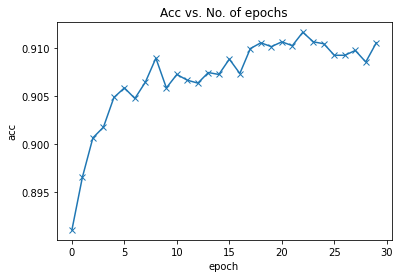

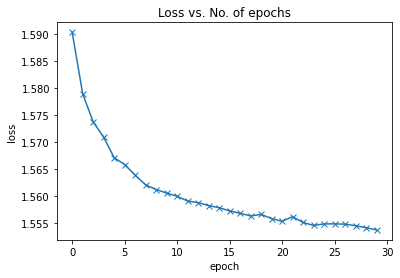

In [ ]:
modelSLR_W0HHLR, historySLR_W0HHLR = experimentSLR(train_ds, val_ds, test_ds, epochs=30, batch_size=32, w_init="zeros", lr=1)

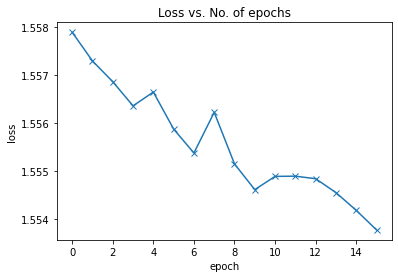

In [ ]:
sub_plot(historySLR_W0HHLR, mode="loss", st=-16, en=None)

With a high learning rate, the covergence is much faster and in this particular scenario it did not stuck any where in local minima. But as seen in the later epochs the loss keep jumping and so its better to select moderate learning rate which gives convergence at decent rate

              precision    recall  f1-score   support

     class 0       0.95      0.98      0.96       980
     class 1       0.98      0.96      0.97      1135
     class 2       0.93      0.88      0.90      1032
     class 3       0.89      0.91      0.90      1010
     class 4       0.90      0.91      0.90       982
     class 5       0.91      0.81      0.86       892
     class 6       0.93      0.94      0.93       958
     class 7       0.92      0.92      0.92      1028
     class 8       0.84      0.91      0.87       974
     class 9       0.88      0.89      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



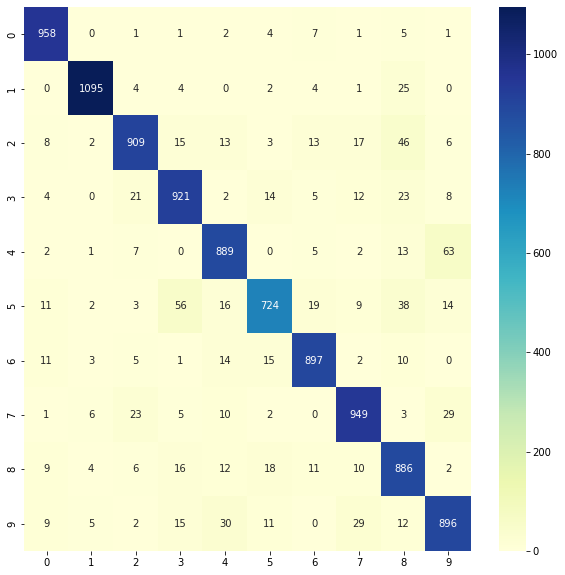

In [ ]:
evaluate_model_test_classification(test_loader, modelSLR_W0HHLR)

### W_zeros Moderate LR

Before training {'val_loss': 2.302727222442627, 'val_acc': 0.09864217042922974}
Epoch [0], val_loss: 1.8795, val_acc: 0.8221
Epoch [1], val_loss: 1.7906, val_acc: 0.8289
Epoch [2], val_loss: 1.7504, val_acc: 0.8374
Epoch [3], val_loss: 1.7261, val_acc: 0.8464
Epoch [4], val_loss: 1.7095, val_acc: 0.8515
Epoch [5], val_loss: 1.6971, val_acc: 0.8544
Epoch [6], val_loss: 1.6874, val_acc: 0.8554
Epoch [7], val_loss: 1.6794, val_acc: 0.8587
Epoch [8], val_loss: 1.6727, val_acc: 0.8618
Epoch [9], val_loss: 1.6670, val_acc: 0.8621
Epoch [10], val_loss: 1.6621, val_acc: 0.8644
Epoch [11], val_loss: 1.6578, val_acc: 0.8660
Epoch [12], val_loss: 1.6539, val_acc: 0.8667
Epoch [13], val_loss: 1.6504, val_acc: 0.8682
Epoch [14], val_loss: 1.6473, val_acc: 0.8689
Epoch [15], val_loss: 1.6445, val_acc: 0.8699
Epoch [16], val_loss: 1.6419, val_acc: 0.8707
Epoch [17], val_loss: 1.6395, val_acc: 0.8717
Epoch [18], val_loss: 1.6373, val_acc: 0.8726
Epoch [19], val_loss: 1.6352, val_acc: 0.8732
Epoch [20]

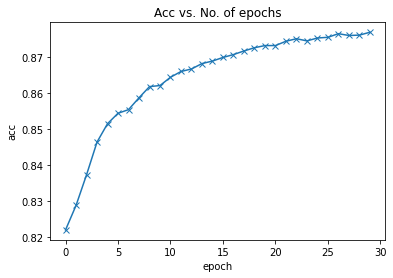

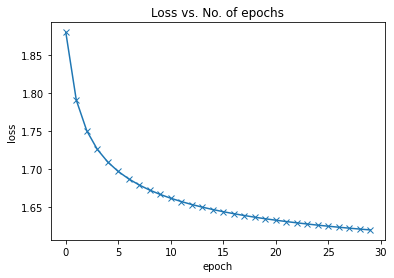

In [ ]:
modelSLR_W0MLR, historySLR_W0MLR = experimentSLR(train_ds, val_ds, test_ds, epochs=30, batch_size=32, w_init="zeros", lr=0.01)

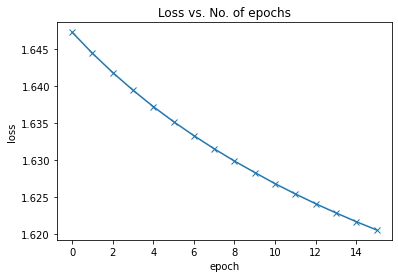

In [ ]:
sub_plot(historySLR_W0MLR, mode="loss", st=-16)

With moderate LR, the Loss decreases very gradually as a result it takes comparitively higher number of epochs but help converge safer than with high LR and jumping between 

### W_zeros Low LR

In [ ]:
# modelSLR_W0MLR, historySLR_W0MLR = experimentSLR(train_ds, val_ds, test_ds, epochs=30, batch_size=32, w_init="zeros", lr=0.0001)

With Low LR, the convergence takes much longer and the number of epochs require to reduce the loss increases significantly.

# SLR Best Params 

Before training {'val_loss': 2.302642822265625, 'val_acc': 0.09794329106807709}
Epoch [0], val_loss: 2.2070, val_acc: 0.7220
Epoch [1], val_loss: 2.1332, val_acc: 0.7505
Epoch [2], val_loss: 2.0751, val_acc: 0.7674
Epoch [3], val_loss: 2.0286, val_acc: 0.7829
Epoch [4], val_loss: 1.9910, val_acc: 0.7940
Epoch [5], val_loss: 1.9603, val_acc: 0.8015
Epoch [6], val_loss: 1.9348, val_acc: 0.8068
Epoch [7], val_loss: 1.9133, val_acc: 0.8111
Epoch [8], val_loss: 1.8950, val_acc: 0.8138
Epoch [9], val_loss: 1.8792, val_acc: 0.8166
Epoch [10], val_loss: 1.8655, val_acc: 0.8193
Epoch [11], val_loss: 1.8533, val_acc: 0.8219
Epoch [12], val_loss: 1.8425, val_acc: 0.8237
Epoch [13], val_loss: 1.8328, val_acc: 0.8244
Epoch [14], val_loss: 1.8241, val_acc: 0.8266
Epoch [15], val_loss: 1.8161, val_acc: 0.8276
Epoch [16], val_loss: 1.8089, val_acc: 0.8288
Epoch [17], val_loss: 1.8023, val_acc: 0.8299
Epoch [18], val_loss: 1.7961, val_acc: 0.8304
Epoch [19], val_loss: 1.7905, val_acc: 0.8308
Epoch [20]

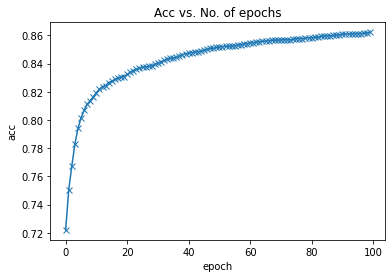

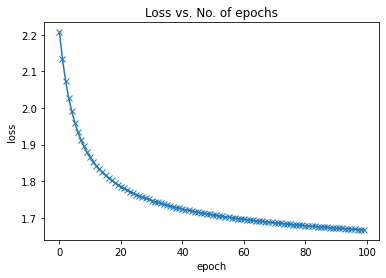

In [ ]:
modelSLR_best, historySLR_best = experimentSLR(train_ds, val_ds, test_ds, epochs=100, batch_size=32, w_init="zeros", lr=0.001)

# Experiment with optimizers

### SGD Optimizer

Before training {'val_loss': 2.302642822265625, 'val_acc': 0.09654552489519119}
Epoch [0], val_loss: 1.8795, val_acc: 0.8156
Epoch [1], val_loss: 1.7907, val_acc: 0.8316
Epoch [2], val_loss: 1.7504, val_acc: 0.8385
Epoch [3], val_loss: 1.7263, val_acc: 0.8473
Epoch [4], val_loss: 1.7096, val_acc: 0.8514
Epoch [5], val_loss: 1.6971, val_acc: 0.8555
Epoch [6], val_loss: 1.6874, val_acc: 0.8562
Epoch [7], val_loss: 1.6794, val_acc: 0.8586
Epoch [8], val_loss: 1.6728, val_acc: 0.8598
Epoch [9], val_loss: 1.6671, val_acc: 0.8623
Epoch [10], val_loss: 1.6622, val_acc: 0.8632
Epoch [11], val_loss: 1.6578, val_acc: 0.8655
Epoch [12], val_loss: 1.6540, val_acc: 0.8667
Epoch [13], val_loss: 1.6505, val_acc: 0.8681
Epoch [14], val_loss: 1.6474, val_acc: 0.8688
Epoch [15], val_loss: 1.6445, val_acc: 0.8697
Epoch [16], val_loss: 1.6419, val_acc: 0.8701
Epoch [17], val_loss: 1.6395, val_acc: 0.8715
Epoch [18], val_loss: 1.6373, val_acc: 0.8726
Epoch [19], val_loss: 1.6353, val_acc: 0.8729


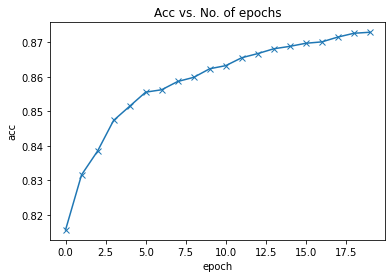

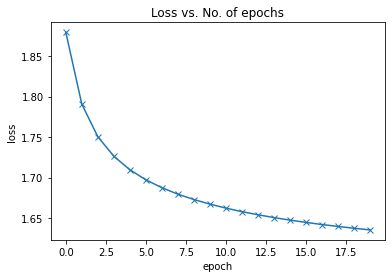

In [ ]:
# smaller batch works better
opt = torch.optim.SGD
modelSLR_SGD, historySLR_SGD = experimentSLR(train_ds, val_ds, test_ds, epochs=20, batch_size=32, w_init="zeros", lr=0.01)

### RMSProp

Before training {'val_loss': 2.3026530742645264, 'val_acc': 0.09045527130365372}
Epoch [0], val_loss: 1.8795, val_acc: 0.8182
Epoch [1], val_loss: 1.7906, val_acc: 0.8331
Epoch [2], val_loss: 1.7504, val_acc: 0.8400
Epoch [3], val_loss: 1.7262, val_acc: 0.8463
Epoch [4], val_loss: 1.7096, val_acc: 0.8520
Epoch [5], val_loss: 1.6971, val_acc: 0.8532
Epoch [6], val_loss: 1.6874, val_acc: 0.8572
Epoch [7], val_loss: 1.6795, val_acc: 0.8579
Epoch [8], val_loss: 1.6727, val_acc: 0.8609
Epoch [9], val_loss: 1.6670, val_acc: 0.8623
Epoch [10], val_loss: 1.6621, val_acc: 0.8639
Epoch [11], val_loss: 1.6578, val_acc: 0.8652
Epoch [12], val_loss: 1.6539, val_acc: 0.8666
Epoch [13], val_loss: 1.6504, val_acc: 0.8678
Epoch [14], val_loss: 1.6473, val_acc: 0.8687
Epoch [15], val_loss: 1.6445, val_acc: 0.8700
Epoch [16], val_loss: 1.6419, val_acc: 0.8706
Epoch [17], val_loss: 1.6395, val_acc: 0.8714
Epoch [18], val_loss: 1.6373, val_acc: 0.8725
Epoch [19], val_loss: 1.6352, val_acc: 0.8732


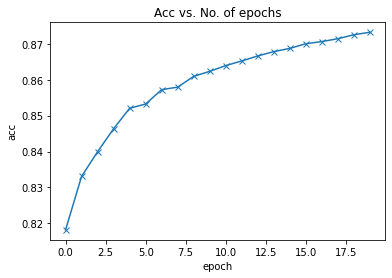

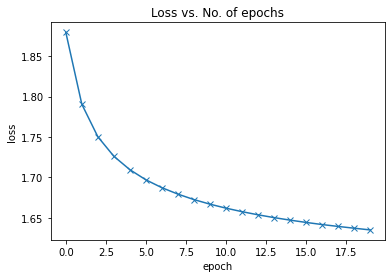

In [ ]:
# smaller batch works better
opt = torch.optim.RMSprop
modelSLR_RMSP, historySLR_RMSP = experimentSLR(train_ds, val_ds, test_ds, epochs=20, batch_size=32, w_init="zeros", lr=0.01)

### Adam

Before training {'val_loss': 2.3025026321411133, 'val_acc': 0.11501597613096237}
Epoch [0], val_loss: 1.6119, val_acc: 0.8885
Epoch [1], val_loss: 1.5860, val_acc: 0.8950
Epoch [2], val_loss: 1.5755, val_acc: 0.9018
Epoch [3], val_loss: 1.5698, val_acc: 0.9036
Epoch [4], val_loss: 1.5657, val_acc: 0.9058
Epoch [5], val_loss: 1.5627, val_acc: 0.9090
Epoch [6], val_loss: 1.5602, val_acc: 0.9066
Epoch [7], val_loss: 1.5591, val_acc: 0.9091
Epoch [8], val_loss: 1.5579, val_acc: 0.9093
Epoch [9], val_loss: 1.5566, val_acc: 0.9114
Epoch [10], val_loss: 1.5555, val_acc: 0.9120
Epoch [11], val_loss: 1.5551, val_acc: 0.9121
Epoch [12], val_loss: 1.5542, val_acc: 0.9122
Epoch [13], val_loss: 1.5535, val_acc: 0.9134
Epoch [14], val_loss: 1.5534, val_acc: 0.9141
Epoch [15], val_loss: 1.5526, val_acc: 0.9140
Epoch [16], val_loss: 1.5520, val_acc: 0.9142
Epoch [17], val_loss: 1.5518, val_acc: 0.9150
Epoch [18], val_loss: 1.5513, val_acc: 0.9156
Epoch [19], val_loss: 1.5511, val_acc: 0.9150


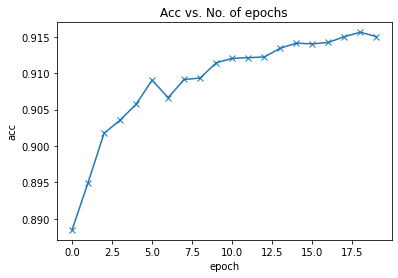

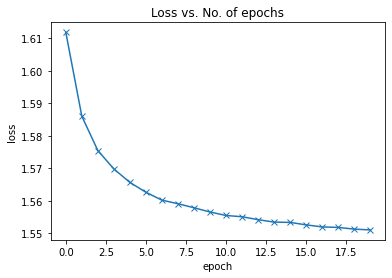

In [ ]:
 # smaller batch works better
opt = torch.optim.Adam
modelSLR_Adam, historySLR_Adam = experimentSLR(train_ds, val_ds, test_ds, epochs=20, batch_size=32, w_init="zeros", lr=0.001, opt=opt)

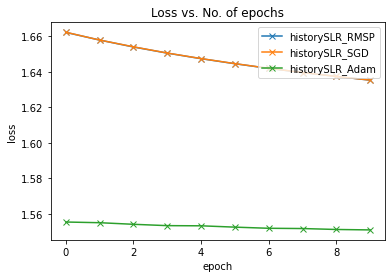

In [ ]:
combine_plot([historySLR_RMSP, historySLR_SGD, historySLR_Adam], ['historySLR_RMSP', 'historySLR_SGD', 'historySLR_Adam'], mode="loss", loc="upper right", st=-10, en=None)

# Regularization L2

Question #2 Consider the L2-regularized multiclass logistic regression. That is, add to the logistic regression loss a regularization term that represents L2 norm of the parameters. More precisely, the regularization term is 

λi(∥wi∥2 + ∥bi∥2)

where {wi, bi} are all the parameters in the logistic regression, and λ ∈ R is the regularization hyper-parameter. Typically, λ is about C/n where n is the number of data points and C is some constant in [0.01,100] (need to tune C). Run the regularized multiclass logistic regression on MNIST, using the basic minibatch SGD, and compare its results to those of the basic minibatch SGD with non-regularized loss, in Question #1.



Before training {'val_loss': 2.3026862144470215, 'val_acc': 0.09622231125831604}
Epoch [0], val_loss: 2.1022, val_acc: 0.7573
Epoch [1], val_loss: 1.9906, val_acc: 0.7929
Epoch [2], val_loss: 1.9231, val_acc: 0.8113
Epoch [3], val_loss: 1.8787, val_acc: 0.8172
Epoch [4], val_loss: 1.8472, val_acc: 0.8235
Epoch [5], val_loss: 1.8235, val_acc: 0.8264
Epoch [6], val_loss: 1.8050, val_acc: 0.8288
Epoch [7], val_loss: 1.7899, val_acc: 0.8323
Epoch [8], val_loss: 1.7775, val_acc: 0.8345
Epoch [9], val_loss: 1.7669, val_acc: 0.8368


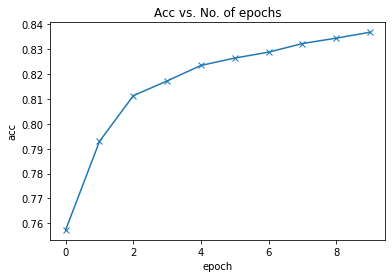

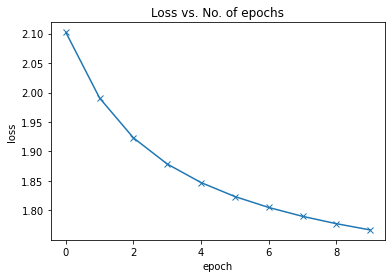

In [ ]:
 # regularized
opt = torch.optim.SGD
modelSLR_R, historySLR_R = experimentSLR(train_ds, val_ds, test_ds, epochs=10, batch_size=128, w_init="zeros", lr=0.01, opt=opt, c=1e-4)

              precision    recall  f1-score   support

     class 0       0.91      0.96      0.94       980
     class 1       0.89      0.93      0.91      1135
     class 2       0.89      0.79      0.83      1032
     class 3       0.77      0.86      0.81      1010
     class 4       0.87      0.82      0.85       982
     class 5       0.89      0.62      0.73       892
     class 6       0.87      0.91      0.89       958
     class 7       0.92      0.83      0.87      1028
     class 8       0.73      0.83      0.78       974
     class 9       0.76      0.87      0.81      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.85      0.84     10000



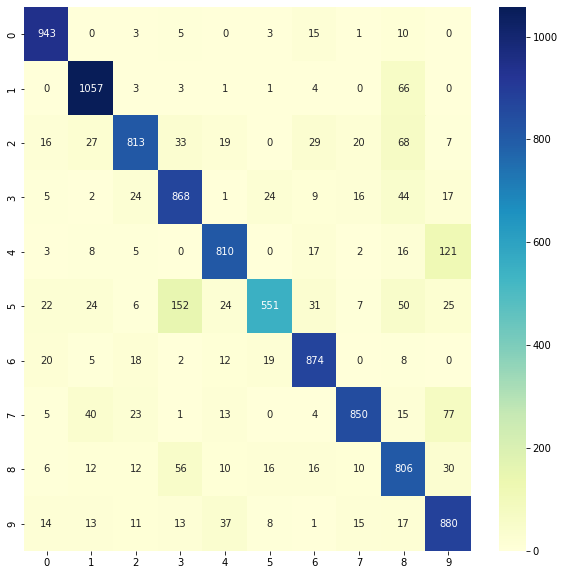

In [ ]:
evaluate_model_test_classification(test_loader, modelSLR_R)

Before training {'val_loss': 2.302612781524658, 'val_acc': 0.1025514230132103}
Epoch [0], val_loss: 2.1023, val_acc: 0.7591
Epoch [1], val_loss: 1.9906, val_acc: 0.7941
Epoch [2], val_loss: 1.9230, val_acc: 0.8100
Epoch [3], val_loss: 1.8785, val_acc: 0.8173
Epoch [4], val_loss: 1.8470, val_acc: 0.8235
Epoch [5], val_loss: 1.8233, val_acc: 0.8262
Epoch [6], val_loss: 1.8047, val_acc: 0.8304
Epoch [7], val_loss: 1.7897, val_acc: 0.8315
Epoch [8], val_loss: 1.7771, val_acc: 0.8350
Epoch [9], val_loss: 1.7665, val_acc: 0.8371


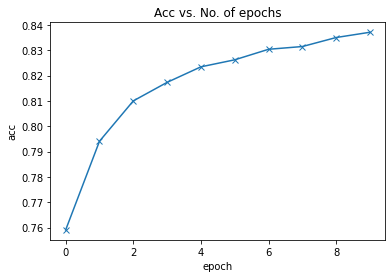

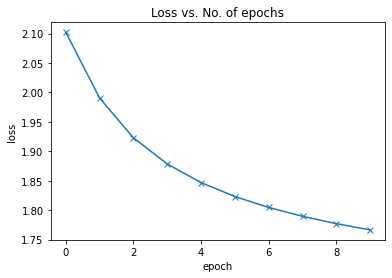

In [ ]:
 # no-regularized
opt = torch.optim.SGD
modelSLR_S, historySLR_S = experimentSLR(train_ds, val_ds, test_ds, epochs=10, batch_size=128, w_init="zeros", lr=0.01, opt=opt, c=0)

              precision    recall  f1-score   support

     class 0       0.91      0.96      0.94       980
     class 1       0.89      0.93      0.91      1135
     class 2       0.88      0.79      0.83      1032
     class 3       0.76      0.86      0.81      1010
     class 4       0.87      0.83      0.85       982
     class 5       0.89      0.61      0.73       892
     class 6       0.87      0.91      0.89       958
     class 7       0.92      0.83      0.87      1028
     class 8       0.74      0.83      0.78       974
     class 9       0.77      0.87      0.81      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.85      0.84     10000



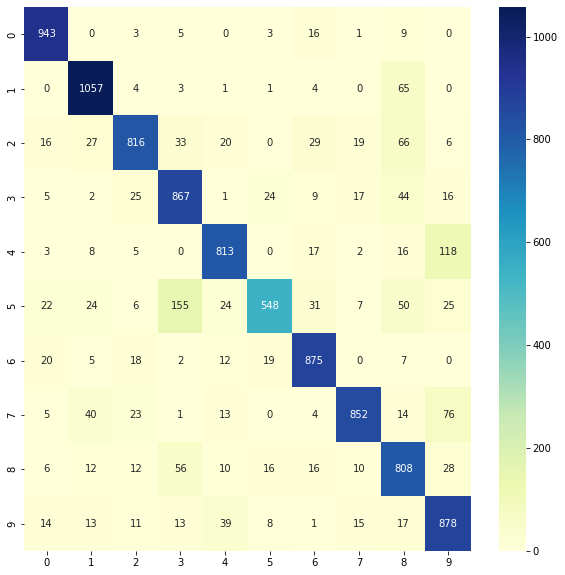

In [ ]:
evaluate_model_test_classification(test_loader, modelSLR_S)

Before training {'val_loss': 2.3025946617126465, 'val_acc': 0.09622231125831604}
Epoch [0], val_loss: nan, val_acc: 0.1018
Epoch [1], val_loss: nan, val_acc: 0.1018
Epoch [2], val_loss: nan, val_acc: 0.1018
Epoch [3], val_loss: nan, val_acc: 0.1018
Epoch [4], val_loss: nan, val_acc: 0.1018


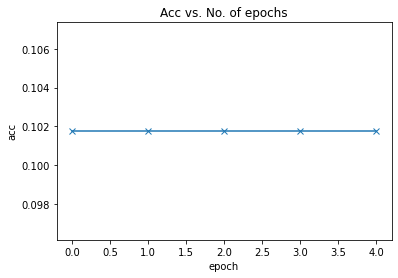

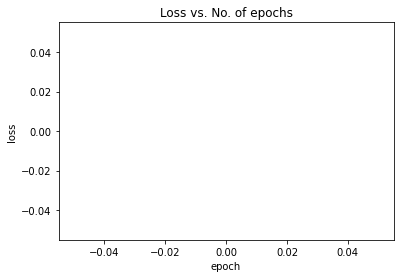

In [ ]:
 # high regularized - high bias model
opt = torch.optim.SGD
modelSLR_HB, historySLR_HB = experimentSLR(train_ds, val_ds, test_ds, epochs=10, batch_size=128, w_init="zeros", lr=0.01, opt=opt, c=1e6)

# LR Hidden Layer NN

In [ ]:
 # not regularized
opt = torch.optim.SGD
modelMLR_wzeros, historyMLR_wzeros = experimentMLR(train_ds, val_ds, test_ds, epochs=30, batch_size=128, w_init="zeros", lr=0.001, opt=opt)

Before training {'val_loss': 2.3098039627075195, 'val_acc': 0.09335443377494812}
Epoch [0], val_loss: 1.6308, val_acc: 0.8868
Epoch [1], val_loss: 1.5840, val_acc: 0.8995
Epoch [2], val_loss: 1.5689, val_acc: 0.9006
Epoch [3], val_loss: 1.5608, val_acc: 0.9046
Epoch [4], val_loss: 1.5551, val_acc: 0.9105
Epoch [5], val_loss: 1.5524, val_acc: 0.9081
Epoch [6], val_loss: 1.5538, val_acc: 0.9056
Epoch [7], val_loss: 1.5470, val_acc: 0.9094
Epoch [8], val_loss: 1.5462, val_acc: 0.9104
Epoch [9], val_loss: 1.5455, val_acc: 0.9121
Epoch [10], val_loss: 1.5442, val_acc: 0.9103
Epoch [11], val_loss: 1.5441, val_acc: 0.9105
Epoch [12], val_loss: 1.5442, val_acc: 0.9118
Epoch [13], val_loss: 1.5428, val_acc: 0.9126
Epoch [14], val_loss: 1.5442, val_acc: 0.9093
Epoch [15], val_loss: 1.5412, val_acc: 0.9127
Epoch [16], val_loss: 1.5428, val_acc: 0.9113
Epoch [17], val_loss: 1.5426, val_acc: 0.9101
Epoch [18], val_loss: 1.5425, val_acc: 0.9092
Epoch [19], val_loss: 1.5452, val_acc: 0.9085
Epoch [20

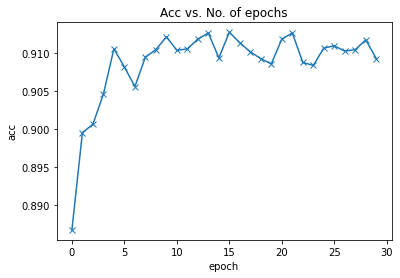

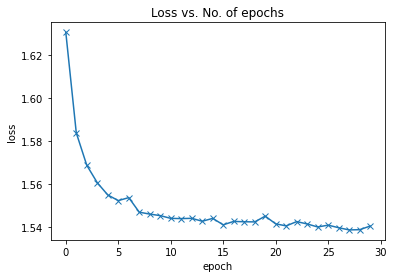

In [ ]:
 # not regularized
opt = torch.optim.Adam
modelMLR_wxv, historyMLR_wxv = experimentMLR(train_ds, val_ds, test_ds, epochs=30, batch_size=128, w_init="xavier_uniform", lr=0.01, opt=opt)

As we include a hidden layer, zero initialization seems to perform worse. A better initialization is xavier_uniform. As the number of param increased the model is needing more epoch to train.
A regularization term will regularize the params and help fsater and more robust converge

              precision    recall  f1-score   support

     class 0       0.94      0.96      0.95       980
     class 1       0.97      0.98      0.98      1135
     class 2       0.93      0.84      0.89      1032
     class 3       0.87      0.89      0.88      1010
     class 4       0.90      0.95      0.93       982
     class 5       0.90      0.82      0.86       892
     class 6       0.94      0.94      0.94       958
     class 7       0.94      0.91      0.93      1028
     class 8       0.80      0.88      0.84       974
     class 9       0.90      0.91      0.91      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



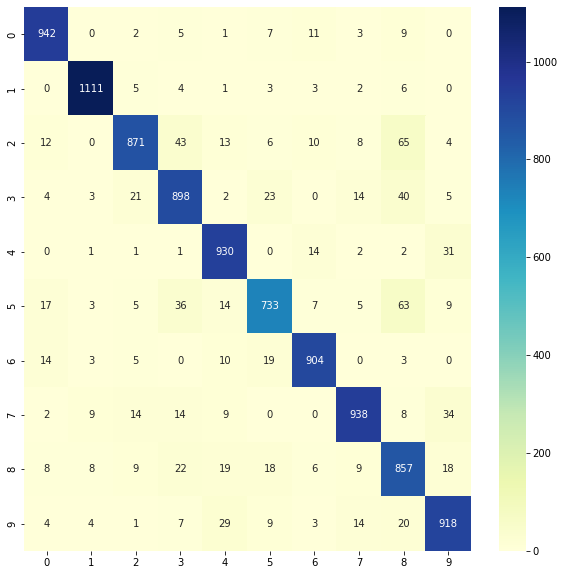

In [ ]:
evaluate_model_test_classification(test_loader, modelMLR_wxv)

Before training {'val_loss': 2.302501916885376, 'val_acc': 0.07763053476810455}
Epoch [0], val_loss: 1.6188, val_acc: 0.8833
Epoch [1], val_loss: 1.5800, val_acc: 0.8965
Epoch [2], val_loss: 1.5669, val_acc: 0.8994
Epoch [3], val_loss: 1.5604, val_acc: 0.9023
Epoch [4], val_loss: 1.5544, val_acc: 0.9062
Epoch [5], val_loss: 1.5519, val_acc: 0.9069
Epoch [6], val_loss: 1.5489, val_acc: 0.9069
Epoch [7], val_loss: 1.5457, val_acc: 0.9082
Epoch [8], val_loss: 1.5503, val_acc: 0.9045
Epoch [9], val_loss: 1.5437, val_acc: 0.9086
Epoch [10], val_loss: 1.5419, val_acc: 0.9096
Epoch [11], val_loss: 1.5420, val_acc: 0.9119
Epoch [12], val_loss: 1.5408, val_acc: 0.9115
Epoch [13], val_loss: 1.5418, val_acc: 0.9107
Epoch [14], val_loss: 1.5394, val_acc: 0.9159
Epoch [15], val_loss: 1.5405, val_acc: 0.9129
Epoch [16], val_loss: 1.5385, val_acc: 0.9151
Epoch [17], val_loss: 1.5369, val_acc: 0.9160
Epoch [18], val_loss: 1.5373, val_acc: 0.9154
Epoch [19], val_loss: 1.5367, val_acc: 0.9142
Epoch [20]

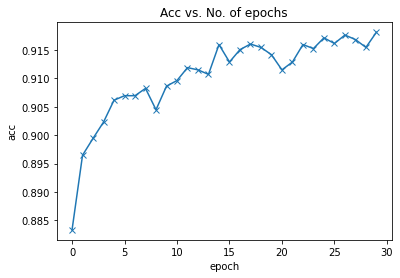

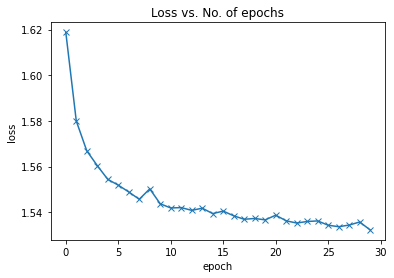

In [ ]:
 # regularized
opt = torch.optim.Adam
modelMLR_wxvR, historyMLR_wxvR = experimentMLR(train_ds, val_ds, test_ds, epochs=30, batch_size=128, w_init="xavier_uniform", lr=0.01, opt=opt, c=1e-6)

              precision    recall  f1-score   support

     class 0       0.94      0.96      0.95       980
     class 1       0.97      0.97      0.97      1135
     class 2       0.93      0.91      0.92      1032
     class 3       0.88      0.91      0.89      1010
     class 4       0.90      0.95      0.92       982
     class 5       0.88      0.85      0.87       892
     class 6       0.92      0.94      0.93       958
     class 7       0.94      0.91      0.93      1028
     class 8       0.90      0.89      0.89       974
     class 9       0.93      0.89      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



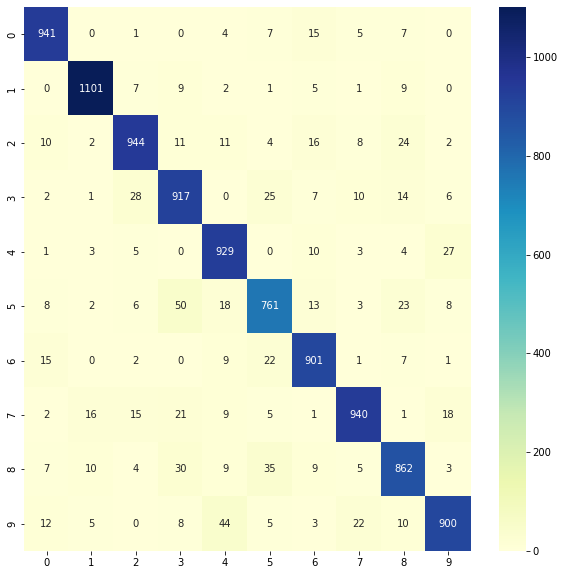

In [ ]:
evaluate_model_test_classification(test_loader, modelMLR_wxvR)

Regularized model seems to perform better when model has more number of param. As observed, regularization helps improve accuracy over unseen test data for a LR with Hidden Layer. However, Regularization perform similar with respect to un-regularized version of simple LR. The effect of regularization becomes more prominent in deep networks. 

# Best Regularized SGDModel

Before training {'val_loss': 2.313849925994873, 'val_acc': 0.04153481125831604}
Epoch [0], val_loss: 2.2988, val_acc: 0.0725
Epoch [1], val_loss: 2.2853, val_acc: 0.1999
Epoch [2], val_loss: 2.2729, val_acc: 0.2919
Epoch [3], val_loss: 2.2611, val_acc: 0.3406
Epoch [4], val_loss: 2.2499, val_acc: 0.3662
Epoch [5], val_loss: 2.2390, val_acc: 0.3865
Epoch [6], val_loss: 2.2284, val_acc: 0.3999
Epoch [7], val_loss: 2.2180, val_acc: 0.4141
Epoch [8], val_loss: 2.2078, val_acc: 0.4278
Epoch [9], val_loss: 2.1977, val_acc: 0.4420
Epoch [10], val_loss: 2.1877, val_acc: 0.4570
Epoch [11], val_loss: 2.1777, val_acc: 0.4687
Epoch [12], val_loss: 2.1677, val_acc: 0.4823
Epoch [13], val_loss: 2.1578, val_acc: 0.4939
Epoch [14], val_loss: 2.1479, val_acc: 0.5078
Epoch [15], val_loss: 2.1381, val_acc: 0.5204
Epoch [16], val_loss: 2.1284, val_acc: 0.5339
Epoch [17], val_loss: 2.1187, val_acc: 0.5446
Epoch [18], val_loss: 2.1092, val_acc: 0.5582
Epoch [19], val_loss: 2.0997, val_acc: 0.5688
Epoch [20]

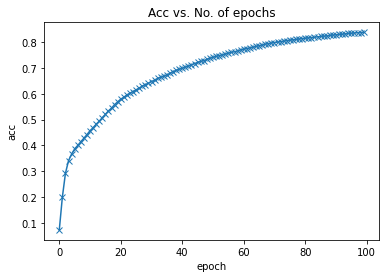

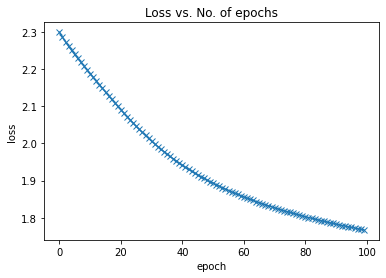

In [ ]:
# Effect of learning rate - lr somehow doesnot have any effect 
 # not regularized
opt = torch.optim.SGD
modelMLR_SGDBestR, historyMLR_SGDBestR = experimentMLR(train_ds, val_ds, test_ds, epochs=100, batch_size=128, w_init="xavier_uniform", lr=0.01, opt=opt, c=1e-6)

still Adam Opt gave better result, increase epoch and retrain sgd or switch graph in report

# Early Stopping MLR

Question #3 Going above and beyond Question-1 and Question-2, investigate the basic minibatch SGD with, at least, another regularization method discussed in class (L1, data augmentation, noise robustness, early stopping, sparse representation, bagging, or dropout). Currently, L2 norm, early stopping, and dropout are the most frequently used regularization methods. You may need to read Chapter-7, which I have started to cover in class.  You may even try CNN if time allows you.

Observing Model training with change in lr

In [ ]:
# from torchsample.modules import ModuleTrainer
# trainer = ModuleTrainer(model)
# model = ModuleTrainer(Network())
# model.compile(loss='nll_loss', optimizer='adam')
# callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
# model.set_callbacks(callbacks)
# model.fit(x_train, y_train, val_data=(x_test, y_test),num_epoch=200, batch_size=128, verbose=1)
# loss = model.evaluate(x_train, y_train)
# y_pred = model.predict(x_train)

In [ ]:
# from pytorch_lightning import Trainer, seed_everything

# seed_everything(42, workers=True)

Global seed set to 42


42

In [ ]:
# !pip install pytorch_lightning

In [ ]:
# ! pip install -r early-stopping-pytorch/requirements.txt

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
modelMLR = MnistModel2(w_init='xavier_uniform')

In [ ]:
 # specify loss function
import torch.nn as nn
import torch.nn.functional as F
criterion = nn.CrossEntropyLoss()

# specify optimizer

optimizer = torch.optim.SGD(modelMLR.parameters(), lr=0.01, weight_decay=1e-6)

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(delta=0.001, patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
batch_size = 128
n_epochs = 1000
# history1 = experiment(train_ds, val_ds, test_ds, epochs=10, batch_size=32, w_init="zeros", lr=0.001)
# early stopping patience; how long to wait after last time validation loss improved.
patience = 5
modelMLR, train_loss, valid_loss = train_model(modelMLR, batch_size, patience, n_epochs)

[   1/1000] train_loss: 1.67789 valid_loss: 1.67723
Validation loss decreased (inf --> 1.677226).  Saving model ...
[   2/1000] train_loss: 1.67596 valid_loss: 1.67538
Validation loss decreased (1.677226 --> 1.675379).  Saving model ...
[   3/1000] train_loss: 1.67412 valid_loss: 1.67355
Validation loss decreased (1.675379 --> 1.673547).  Saving model ...
[   4/1000] train_loss: 1.67230 valid_loss: 1.67181
Validation loss decreased (1.673547 --> 1.671813).  Saving model ...
[   5/1000] train_loss: 1.67055 valid_loss: 1.67011
Validation loss decreased (1.671813 --> 1.670113).  Saving model ...
[   6/1000] train_loss: 1.66891 valid_loss: 1.66848
Validation loss decreased (1.670113 --> 1.668482).  Saving model ...
[   7/1000] train_loss: 1.66725 valid_loss: 1.66690
Validation loss decreased (1.668482 --> 1.666896).  Saving model ...
[   8/1000] train_loss: 1.66567 valid_loss: 1.66536
Validation loss decreased (1.666896 --> 1.665359).  Saving model ...
[   9/1000] train_loss: 1.66412 valid

145


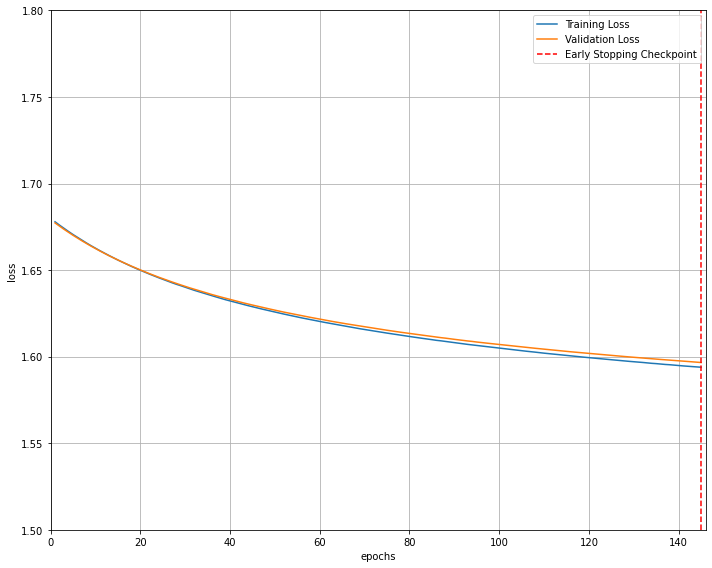

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
print(minposs)
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(1.5, 1.8) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

              precision    recall  f1-score   support

     class 0       0.92      0.97      0.95       980
     class 1       0.96      0.97      0.97      1135
     class 2       0.91      0.88      0.90      1032
     class 3       0.86      0.89      0.88      1010
     class 4       0.70      0.18      0.29       982
     class 5       0.89      0.79      0.84       892
     class 6       0.93      0.94      0.94       958
     class 7       0.92      0.88      0.90      1028
     class 8       0.86      0.88      0.87       974
     class 9       0.50      0.89      0.64      1009

    accuracy                           0.83     10000
   macro avg       0.85      0.83      0.82     10000
weighted avg       0.85      0.83      0.82     10000



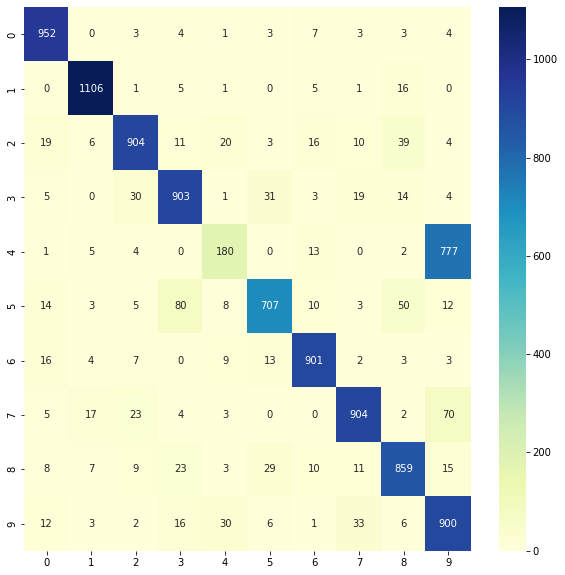

In [ ]:
evaluate_model_test_classification(test_loader, modelMLR)

# Dropout MLR

In [ ]:
ep = 150 # From Early Stopping with n=1000 and tol=0.001, p=5
# calculate test acc on Early stop and same epoch model with dropout 
opt = torch.optim.SGD
modelMLR_Drp, historyMLR_Drp = experimentMLR(train_ds, val_ds, test_ds, epochs=ep, batch_size=128,
                                             w_init="xavier_uniform", lr=0.01, opt=opt, c=1e-6,
                                             dropout_=0.3)

Before training {'val_loss': 2.3117146492004395, 'val_acc': 0.09543117135763168}
Epoch [0], val_loss: 2.2997, val_acc: 0.1046
Epoch [1], val_loss: 2.2867, val_acc: 0.1397
Epoch [2], val_loss: 2.2773, val_acc: 0.1645
Epoch [3], val_loss: 2.2662, val_acc: 0.1894
Epoch [4], val_loss: 2.2578, val_acc: 0.2106
Epoch [5], val_loss: 2.2473, val_acc: 0.2419
Epoch [6], val_loss: 2.2399, val_acc: 0.2611
Epoch [7], val_loss: 2.2295, val_acc: 0.2822
Epoch [8], val_loss: 2.2220, val_acc: 0.2978
Epoch [9], val_loss: 2.2126, val_acc: 0.3211
Epoch [10], val_loss: 2.2059, val_acc: 0.3279
Epoch [11], val_loss: 2.1972, val_acc: 0.3435
Epoch [12], val_loss: 2.1892, val_acc: 0.3612
Epoch [13], val_loss: 2.1794, val_acc: 0.3668
Epoch [14], val_loss: 2.1708, val_acc: 0.3838
Epoch [15], val_loss: 2.1662, val_acc: 0.3876
Epoch [16], val_loss: 2.1591, val_acc: 0.3917
Epoch [17], val_loss: 2.1504, val_acc: 0.3976
Epoch [18], val_loss: 2.1438, val_acc: 0.4112
Epoch [19], val_loss: 2.1360, val_acc: 0.4143
Epoch [20

In [ ]:
evaluate_model_test_classification(test_loader, modelMLR_Drp)

NameError: ignored